<a href="https://colab.research.google.com/github/jpatrickbouchet/land-cover-on-demand/blob/master/4_Serving.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install tensorflow==2.0.0-beta1

In [0]:
import os
import datetime
import time
import json
from io import BytesIO

import tensorflow as tf
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [0]:
print(tf.__version__)

2.0.0-beta1


In [0]:
from google.colab import auth
auth.authenticate_user()

In [0]:
PROJECT = 'PROJECT_ID_HERE'
BUCKET = 'BUCKET_NAME_HERE'
REGION = 'us-central1'

In [0]:
os.environ['BUCKET'] = BUCKET
os.environ['PROJECT'] = PROJECT
os.environ['REGION'] = REGION

In [0]:
BUCKET_DIR = "gs://{0}/".format(BUCKET)

In [0]:
%%bash
gcloud config set project ${PROJECT}

Updated property [core/project].


## Reload model using the h5 file

In [0]:
# Copying from gcs to local environment
%%shell
gsutil -m cp gs://${BUCKET}/saved_models/model_20190815.h5 .

In [0]:
# Loading model
model = tf.keras.models.load_model('model_20190815.h5')

## Wrapping model with custom input functions for serving

In [0]:
class ExportModel(tf.keras.Model):

    def __init__(self, model):
        super().__init__(self)
        self.model = model
        self.img_size = 256

    @tf.function
    def decode_patch_data(self, patch_bytes):
        image = tf.io.decode_raw(patch_bytes, tf.float32)
        image = tf.reshape(image, [self.img_size, self.img_size, 3])
        return image*2 - 1


    @tf.function
    def post_proc(self, onehot_mask):
        mask = tf.argmax(onehot_mask, axis=-1)
        mask = tf.cast(mask, tf.uint8)
        mask = tf.expand_dims(mask, axis=-1)
        mask = tf.image.encode_png(mask)
        mask = tf.io.encode_base64(mask)
        return mask


    @tf.function(input_signature=[tf.TensorSpec([None,], dtype=tf.string, name="patches_bytes")])
    def default_serving_fn(self, patches_bytes):
        
        images = tf.map_fn(self.decode_patch_data,
                           patches_bytes,
                           back_prop=False,
                           dtype=tf.float32)

        predictions = self.model(images)
        
        masks = tf.map_fn(self.post_proc,
                           predictions,
                           back_prop=False,
                           dtype=tf.string)

        return masks

    
    @tf.function(input_signature=[tf.TensorSpec([None], dtype=tf.string, name="tfrec_serialized_examples")])
    def batch_serving_fn(self, tf_example):

        keys_to_features = {
            'patch_id': tf.io.FixedLenFeature([], dtype=tf.int64),
            'patch_data': tf.io.FixedLenFeature([], dtype=tf.string),
        }           
        
        features = tf.io.parse_example(tf_example, keys_to_features)

        patches_id = features['patch_id']
        patches_bytes = features['patch_data']
        
        masks = self.default_serving_fn(patches_bytes)

        return { "patches_id": patches_id, "masks": masks }

In [0]:
# Create the ExportModel
serving_model = ExportModel(model)

In [0]:
# Export to the Tensorflow SavedModel format
export_path = os.path.join(BUCKET_DIR, 'export_models', str(time.time()))

tf.keras.backend.set_learning_phase(0) #inference only

tf.saved_model.save(serving_model,
                    export_path,
                    signatures={
                        "serving_default": serving_model.default_serving_fn,
                        "serving_batch": serving_model.batch_serving_fn
                    })

print('Model saved to: {}'.format(export_path))

In [0]:
# Double checking signatures using saved model cli

%%shell
saved_model_cli show --dir gs://${BUCKET}/export_models/1565895213.3011768/ --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_batch']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['tfrec_serialized_examples'] tensor_info:
        dtype: DT_STRING
        shape: (-1)
        name: serving_batch_tfrec_serialized_examples:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['masks'] tensor_info:
        dtype: DT_STRING
        shape: (-1)
        name: StatefulPartitionedCall:0
    outputs['patches_id'] tensor_info:
        dtype: DT_INT64
        shape: (-1)
        name: StatefulPartitionedCall:1
  Method name is: tensorflow/serving

## Preparing sample data to test our deployed model

### For local and online prediction

In [0]:
def dataset_parser(example_proto):    
    patch_dimension_flat = [256 * 256, 1]
    
    keys_to_features = {
        'B4': tf.io.FixedLenFeature(patch_dimension_flat, dtype=tf.float32),
        'B3': tf.io.FixedLenFeature(patch_dimension_flat, dtype=tf.float32),
        'B2': tf.io.FixedLenFeature(patch_dimension_flat, dtype=tf.float32),
        'landcover': tf.io.FixedLenFeature(patch_dimension_flat, dtype=tf.int64)
    }
      
            
    parsed = tf.io.parse_single_example(example_proto, keys_to_features)

    band_shape = [256, 256]
    red_img = tf.reshape(parsed['B4'], band_shape)
    green_img = tf.reshape(parsed['B3'], band_shape)
    blue_img = tf.reshape(parsed['B2'], band_shape)
    image_rgb = tf.stack((red_img, green_img, blue_img), axis=-1)
    
    landcover_mask = tf.reshape(parsed['landcover'], [256, 256, 1])
    
    return image_rgb, landcover_mask

In [0]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Getting list of tfrecords files
tfrec_file_pattern = os.path.join(BUCKET_DIR, 'valid_images_.tfrecord.gz')
tfrec_files = tf.data.Dataset.list_files(tfrec_file_pattern)
  
# Reading tfrecords
patches_ds = tf.data.TFRecordDataset(tfrec_files, compression_type='GZIP')

# Parsing tfrecords into tf.Example
patches_ds = patches_ds.map(dataset_parser, num_parallel_calls=AUTOTUNE)

In [0]:
patches_ds_iter = iter(patches_ds)

In [0]:
image_rgb, ground_truth = next(patches_ds_iter)

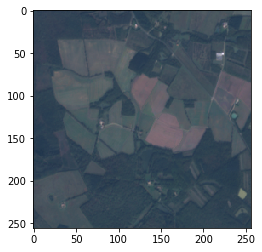

In [0]:
plt.imshow(image_rgb)

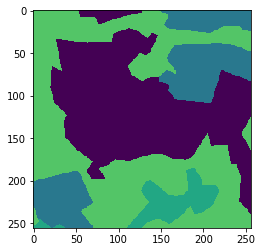

In [0]:
plt.imshow(np.squeeze(ground_truth), vmin=0, vmax=15)

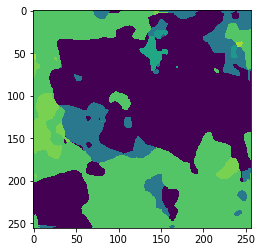

In [0]:
pred_test = model.predict([[image_rgb*2-1]])
pred_test = tf.argmax(pred_test, axis=-1)
plt.imshow(np.squeeze(pred_test), vmin=0, vmax=15)

In [0]:
## Create input json file
import base64

json_prep = image_rgb.numpy().tostring()
json_prep = base64.b64encode(json_prep).decode('utf-8')

instances = {'b64': json_prep}

with open('test_input.json', 'w') as jsfile:
    jsfile.write(json.dumps(instances))

### For batch prediction

In this case we need to add a way to retrieve the original order of the patches.  
To do so, I deserialize each the tfrecords generated by Google Earth Engine and reserialize them with a patch_id attached to each example.

In [0]:
def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def serialize_example(idx, patch_data):
    """
    Creates a tf.Example message ready to be written to a file.
    """
    
    patch_data = patch_data.numpy()
    
    feature = {
        'patch_id': _int64_feature(idx),
        'patch_data': _bytes_feature(patch_data.tostring())
    }

    # Create a Features message using tf.train.Example.
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

In [0]:
# Generating ids to assign to each patch
idx = tf.data.Dataset.range(0, 60)

# Combining ids and patches in one dataset
patches_batch_ds = tf.data.Dataset.zip((idx, patches_ds))

def serialize_generator():
    for features in patches_batch_ds:
        yield serialize_example(features[0], features[1][0])


serialized_dataset = tf.data.Dataset.from_generator(
    serialize_generator, output_types=tf.string, output_shapes=())


serialized_dataset

W0816 08:54:38.070632 139641409841024 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:505: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


<DatasetV1Adapter shapes: (), types: tf.string>

In [0]:
# Saving
filename = 'test_batch_pred.tfrec'
writer = tf.data.experimental.TFRecordWriter(filename)
writer.write(serialized_dataset)

## Test local predictions

In [0]:
%%shell
gcloud ai-platform local predict --model-dir gs://${BUCKET}/export_models/1565895213.3011768/ \
  --json-instances test_input.json \
  --framework tensorflow \
  --signature-name serving_default

Since local prediction doesn't seem to work in Collab, I ran it on my laptop and copied the response below

In [0]:
# Local prediction received on my machine
local_prediction = "iVBORw0KGgoAAAANSUhEUgAAAQAAAAEACAAAAAB5Gfe6AAAMmUlEQVR4nO1daXOrOgwVJDC3Q___Ly2Td6FN3gc2L7It27IRzT0zbbNQ4BwkeUEWzQA8mI33k_GedpzG-sTcT-T3PbJhr3w_NUwCmPxBPzXqURrrP8PwbN0b7yfrE-ASwFYghb9lAWEp_FtofCfrEwC4h08qDRNABPENL12BaeVnXTf9ML6z6I-X5icAUFCANMtqAAC-rI8nlwJxzoKhzd4DN75s_m64TYO6KZsFdHoQ6FL2MTq_QaLX-nku-FxAUyCBv5s9AOBeQKAfNBHGGNAhTSEZAfpgKpB_6VdwBsFuawuT7D-I6bieSfR7tEXhbQW4mPcOjpP7K9JeS3aEcqH5QA9cRh6MAfKaQVjPOqKFy4FIARZwKBDeh0QBeuNv_p48KNYV5kCfGQgU_mt4tltqMRbAH4x7mz_STIkR4ABT9FN30yGvVtQXINDn-9Dma9IPQ5WxZj_goI4edAQwzztdAH0_6nU3wkA1AYwLjx12tGewUuHmbwpQyQVG0_AxR6jT9TGiQI1mEPX60bKBnMGkAbKUXQ0BwiNdFYtJPo-XCTD4G9d8H7Z3ADUswMHfbwAL9z__JR0xdP01QcT0A1b--vn8SdlTXCg5qytsGgDKPwWxkfQkCzD5x8UJN3qEv3-W5hwLoHQ-vu8AkTEgpR09RQCLP2IA3_B9j-PvoB-YppMyHL4BAMDP_v4bYq9_YjdKSivwAACA23N9-73-0JHajeS3gMWcB-2duYnhA8dGt8fW8sXR92CuGQRH5BW-nTMM_gd_gJE-AMzeMBASwCSCjuLiTuj4n-F4_XF8ldb982HpZOAy-IfDXM1zGLsAj9Q9hIMAqoA3CNbjz4Dw5ME-2lBJC2kGP8KbBOG6hW6iBWjhqbz7PQgZwQxt2xqMf5UABAUsyBDgA32ZAOos4u4BQgTgg0-Btm3_Lq-eyodFT4cIjhAYRgsA7Qyg8fcLICV3IAZOE1gnG__-far8JTSDda7_ivZpdI1PFqAq-R3q-OhcATD-H4_jq5R-sTOrFAA291cU8AfB0kHATfBD-c2Izf2PDoGAGGAil7XfBFbsNnByM5g89vOB1BvabECgBeQjlGOvIiDAUHpE_CjXDqyGENDh3uodo-p4OHz-AXuDwIjW4hqKARU6g26WBSKExbfFPqyMR5FQ6IBJ1k2-sZewFUMNCRbjf5o-4Lv6FRUo0x4CgNIoPp9Piz5A-zo5CG6o6QYqWng5vnF9XgfV9GittXo7FgXOmROowJ-QknGeDVT0hxagbrSThsUChCnwE96EjkBXeHUBUQrU5L8Phhqnw_dsS_SIYOWvAl09fnY3-EClwGdeTjkCbHjgMxof-ePm5eIbOw9OiDCmMJPw4FsVC4CGgO0u8qzlCrtCgJgUgSgPGfDz3hZhTXAoswiA0T-H-iNjaawKlwT7vifo5w5muPUO-rVNH-C7gyUm5TcDPQD0M8CWf3jgduz856d5OoPgWZb_A8C2cgQfxZjZxLgAJ5n_g6sLQDz_CWCS1wyyYFx_sHhCqCJzWuhfbupwBMGdQugewT121MsUpR0otWu14dORcmeorAbFgIuACUDwgNx13WfBPmuupWmXRA--SVEHdg1_gwKwTIu_LSZIcYFrOr8TmACBmfB1RPUbhJjSmsHfQH3FJHBGqDL-CXD2CZwNVIAr5gin4p8FnH0CZwMX4I184J8F4B-_jwm4LOBtFHh7FyieLD0Iur2GobQFDAAwSPYnc_X4kiryAqbrtu9drBXoLrBlyrjzReIwqK9kaqAKwJ4oNBjvJEqwC1AgTcpyfYkSbEGwBn_HZ-fCkSbHoAfOVZwCb98RcglQLHNSmgk4U2WLVVsVpoBnyUzFszgRnhjwybH_0aonKwyLpeNXO-J5N1jKwNH5c5YOE4BmALe1UxUIPvpDV0CUAN5mkOgE-43yvsdKWoIwyjr8_YBP6HsnKxxXU8DrAqBbtcPCSRXBFSeQJcatB68A6mrj2-12u1m5jNYltzcBgPnYrH4Srg-BKbHX8fSkFYQn4PjXmMgyAMpYwC7Dp0YFzOexz0bjrxT4Y8A6MYQbLboER_9WxwDy-OcIEMBF8khaAHey7PZ5mYenyUCxpbMXMYBVgDdOFvRYwKFKQgy4igGUmhK7DP9_c4JrTxApokDzgOnqWdNOC6DFxQlQc7-OB2wWkDUBSCrfBrDbiih5WoCmQUoGKQYQ0waI4kYC6gKvF7Vj4Hg6KG4SIoNFa1s_mT0AQK_zEsnRi7vBP7pPaFdkCNZlql6Twgf2HKEnwKVCQbgjlNBAXIh_WIBfzj_gAm9wf9C0gMZ-c73IHoOa9QRFuoYlQD5rN88ptMEJsGOAnSPI126Lor7g7ecDEAHeIPQrwCzAUiCqHRBo5j68vQugHaGcXOkzDWAAiLn5NgD4e4KuaqtSEZeAt27tdYHdEOiX9UQDGLQ_VPjHAq_f2yZsOgWDYNT8kAADiAWtFfgsQSwu-SqEAXlFAUGAFzBljdoQMNDEZ4Xtt7RTjTEUx4RyIpJTsMkdoUIXq8Ruo8QgCfD1BbRTjaDDy9xcnkUHKoDd9FEViEeRvUYoEDMWIJxrAh0OBez1acHVqluPGe8I2YOBrwEAOhixvNhMCoXukxAHBo2rgdMkUB6VPWp87XqNRDaaaLkKBK42rsL6T04BfKWWj7PHnuZEomNYTZ4EQZdHJVj-K_iYHSsgDgNM3kJiKR7B2im04YkI3mnxBqBBmoQB_A_ySiKT0THOWofmdoEdrrrbRwVY-9SDJu1gm-IKNP62F4RcIHjQhXuPkgldTtfXfV-v2sIiSert8WMhuINLetnVuknl6fkBwUcREpZWWNjSsiPqLWRazCHA4uoRE0ADIXvKUYLY5QFqWnqlmhNbouT2PmYitCPljyEaUPgD0Aou5IYMK1vcivmeKbGOuJBAJ-wMkMjeyofEOg9d7bFOswlczdJPPW0GaIyLHJc3Rk-jDCSUuq3JJwHZQrCdDLA8bS5ruQR9OU0q_7IVB4IuEFSHEgpXdu4t_TKWdAOsUITmAwTzCCmgsMM3DVuRS4EI43D4ANYV5l1BpDUVKFWCF5VrDRzJ0sdLwj68BIwvu12PzrGFA9kSYKO-0Vcr5SirFkSqb0fCNaCjYHVrqyTE4A6C-Y7Avd4yoxLXFtY-LQlYOkJIQ1BmsWmqBO7-_ciSIjManf2O2keOR1IkUPmboYDDAkZ18Vjpdcbcg0QGAdbzWR7jV2OddawG3gFufsUs9Vwqlskayccz-ethMDsGjM43FcBwPOY8QXEFIoJzXLkCmIwrK0C49xf4nj1TVJgNBGf4MgVA6NZVIHC08AxngVxhUQr40fd9iWTpKgqQalajBqAn1MV1hPD6gFKB2_82yOuXUSxZgFF7LUCC4DyZk_-gJnnQXGA2C2NKiPX-i4CUBABABvkEAcbRHO2BDGeIP_g21aVMULeBpsJZFFW4AigpZI6nu4NngQjF0JE5ikxRZgDyRGHUjlGazdC4vgrRd1VKzeK_zy1ljqsRCzhIKkGwu6P3gxNiHIsv8BWbtFk5zNxqBuncR27_Z621-SLe37mr357buHHXGlUk0OmP6o3a-2-lD7D7gfPqd7PaD4jnz6jYXKbU7Ov18pQE6qA7YsDvu_wkdKsFJJaA51KtMv81eC8NbZN3752nIUAFqFTItBUwrDm11HTuwlAGE3Dxr2MCb798nntanBF1PEOwBUxVwpNcAabk1jkKAgTwBbvyCuSXByjUDmAPrSkBARaAwjkLyYFZGXqIEICWUcOmwAyK0YkQoG4B_1n5LUYAkhHwmMCs_5UigGkE1WpL5AvA5ppBI2Ced11eybGAkyBKgDOeZSJKgBoKmIeQJYBXAaauoHEIYQLUgK6ANAFqhIFO_ZMvQK0b5IzHUVWus3AyAUVL0CsKZFsAtwG4fKCUoeUKICBbKg-ZAhTkr48Gih0oKwZc_vJDngUU5q-aQLlDZQhQ8_qXmxxNF6A8f9UEiikgrSeotYM1FEgWoJwBKBMjFeaF0u8LlHWBbeJG6Q-WOaA8F1hQblA06_lIYscCZbBOibOMBQrftlvPkTcKIPfgpLoAVlUpG9g9yAwBSt-5XRQo0RCo2rZDenGKOgoU3m-bY1o1FeBoBDtrr6sLJO-8ggKsE0NdZ91_4l85ygr2UhTW_gRniWkoXEdI8MxG6VPjLaBQAsP-qwgE3R4_BxcYC5R1Aoau8LVNgGMscGkF5A6GKmEVIM_PrmwCWxA8qiSLe17gDCUniO7HQVZYT08gYC44g1X4AKsAnTlZEGcHBdMauojF5Cn4Hw4qc-_R7Lt5AAAAAElFTkSuQmCC"

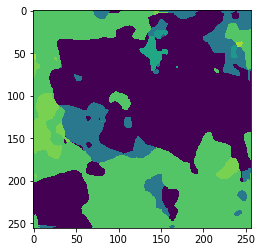

In [0]:
local_prediction.encode('utf-8')
local_prediction = tf.io.decode_base64(local_prediction)
local_prediction = tf.io.decode_png(local_prediction)
plt.imshow(np.squeeze(local_prediction), vmin=0, vmax=15)

The saved model seems to work as expected. Let's deploy it.

## Deploy the model to Google AI platform

In [0]:
# Create model in google ai platform
!gcloud ai-platform models create land_segm \
   --regions us-central1

In [0]:
# Create a version
%%shell
gcloud ai-platform versions create v1 \
  --model land_segm \
  --origin gs://${BUCKET}/export_models/1565895213.3011768/ \
  --runtime-version=1.14 \
  --framework TENSORFLOW \
  --python-version=3.5



To take a quick anonymous survey, run:
  $ gcloud alpha survey



## Test online prediction

In [0]:
%%shell
gcloud ai-platform predict --model land_segm \
                   --version v1 \
                   --json-instances test_input.json \
                   --signature-name serving_default

OUTPUT_0
iVBORw0KGgoAAAANSUhEUgAAAQAAAAEACAAAAAB5Gfe6AAAMmUlEQVR4nO1daXOrOgwVJDC3Q___Ly2Td6FN3gc2L7It27IRzT0zbbNQ4BwkeUEWzQA8mI33k_GedpzG-sTcT-T3PbJhr3w_NUwCmPxBPzXqURrrP8PwbN0b7yfrE-ASwFYghb9lAWEp_FtofCfrEwC4h08qDRNABPENL12BaeVnXTf9ML6z6I-X5icAUFCANMtqAAC-rI8nlwJxzoKhzd4DN75s_m64TYO6KZsFdHoQ6FL2MTq_QaLX-nku-FxAUyCBv5s9AOBeQKAfNBHGGNAhTSEZAfpgKpB_6VdwBsFuawuT7D-I6bieSfR7tEXhbQW4mPcOjpP7K9JeS3aEcqH5QA9cRh6MAfKaQVjPOqKFy4FIARZwKBDeh0QBeuNv_p48KNYV5kCfGQgU_mt4tltqMRbAH4x7mz_STIkR4ABT9FN30yGvVtQXINDn-9Dma9IPQ5WxZj_goI4edAQwzztdAH0_6nU3wkA1AYwLjx12tGewUuHmbwpQyQVG0_AxR6jT9TGiQI1mEPX60bKBnMGkAbKUXQ0BwiNdFYtJPo-XCTD4G9d8H7Z3ADUswMHfbwAL9z__JR0xdP01QcT0A1b--vn8SdlTXCg5qytsGgDKPwWxkfQkCzD5x8UJN3qEv3-W5hwLoHQ-vu8AkTEgpR09RQCLP2IA3_B9j-PvoB-YppMyHL4BAMDP_v4bYq9_YjdKSivwAACA23N9-73-0JHajeS3gMWcB-2duYnhA8dGt8fW8sXR92CuGQRH5BW-nTMM_gd_gJE-AMzeMBASwCSCjuLiTuj4n-F4_XF8ldb982HpZOAy-IfDXM1zGLsAj9Q9hIMAqoA3CNbjz4Dw5ME-2lBJC2kGP8KbBOG6hW6iBWjhqbz7PQgZwQxt2xqMf5UABAUsyBDgA32ZAOos4u4BQgTgg0-Btm3_Lq-eyodFT4c

## Test batch prediction

In [0]:
%%shell
gcloud ai-platform jobs submit prediction batch_pred_test1 \
    --model land_segm \
    --input-paths gs://${BUCKET}/test_batch_pred.tfrec \
    --output-path gs://${BUCKET}/output/ \
    --region us-central1 \
    --data-format TF_RECORD \
    --signature-name serving_batch \
    --version v1

Job [batch_pred_test1] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ai-platform jobs describe batch_pred_test1

or continue streaming the logs with the command

  $ gcloud ai-platform jobs stream-logs batch_pred_test1
jobId: batch_pred_test1
state: QUEUED


In [0]:
# One prediction received from batch
batch_prediction = "iVBORw0KGgoAAAANSUhEUgAAAQAAAAEACAAAAAB5Gfe6AAAMmUlEQVR4nO1daXOrOgwVJDC3Q___Ly2Td6FN3gc2L7It27IRzT0zbbNQ4BwkeUEWzQA8mI33k_GedpzG-sTcT-T3PbJhr3w_NUwCmPxBPzXqURrrP8PwbN0b7yfrE-ASwFYghb9lAWEp_FtofCfrEwC4h08qDRNABPENL12BaeVnXTf9ML6z6I-X5icAUFCANMtqAAC-rI8nlwJxzoKhzd4DN75s_m64TYO6KZsFdHoQ6FL2MTq_QaLX-nku-FxAUyCBv5s9AOBeQKAfNBHGGNAhTSEZAfpgKpB_6VdwBsFuawuT7D-I6bieSfR7tEXhbQW4mPcOjpP7K9JeS3aEcqH5QA9cRh6MAfKaQVjPOqKFy4FIARZwKBDeh0QBeuNv_p48KNYV5kCfGQgU_mt4tltqMRbAH4x7mz_STIkR4ABT9FN30yGvVtQXINDn-9Dma9IPQ5WxZj_goI4edAQwzztdAH0_6nU3wkA1AYwLjx12tGewUuHmbwpQyQVG0_AxR6jT9TGiQI1mEPX60bKBnMGkAbKUXQ0BwiNdFYtJPo-XCTD4G9d8H7Z3ADUswMHfbwAL9z__JR0xdP01QcT0A1b--vn8SdlTXCg5qytsGgDKPwWxkfQkCzD5x8UJN3qEv3-W5hwLoHQ-vu8AkTEgpR09RQCLP2IA3_B9j-PvoB-YppMyHL4BAMDP_v4bYq9_YjdKSivwAACA23N9-73-0JHajeS3gMWcB-2duYnhA8dGt8fW8sXR92CuGQRH5BW-nTMM_gd_gJE-AMzeMBASwCSCjuLiTuj4n-F4_XF8ldb982HpZOAy-IfDXM1zGLsAj9Q9hIMAqoA3CNbjz4Dw5ME-2lBJC2kGP8KbBOG6hW6iBWjhqbz7PQgZwQxt2xqMf5UABAUsyBDgA32ZAOos4u4BQgTgg0-Btm3_Lq-eyodFT4cIjhAYRgsA7Qyg8fcLICV3IAZOE1gnG__-far8JTSDda7_ivZpdI1PFqAq-R3q-OhcATD-H4_jq5R-sTOrFAA291cU8AfB0kHATfBD-c2Izf2PDoGAGGAil7XfBFbsNnByM5g89vOB1BvabECgBeQjlGOvIiDAUHpE_CjXDqyGENDh3uodo-p4OHz-AXuDwIjW4hqKARU6g26WBSKExbfFPqyMR5FQ6IBJ1k2-sZewFUMNCRbjf5o-4Lv6FRUo0x4CgNIoPp9Piz5A-zo5CG6o6QYqWng5vnF9XgfV9GittXo7FgXOmROowJ-QknGeDVT0hxagbrSThsUChCnwE96EjkBXeHUBUQrU5L8Phhqnw_dsS_SIYOWvAl09fnY3-EClwGdeTjkCbHjgMxof-ePm5eIbOw9OiDCmMJPw4FsVC4CGgO0u8qzlCrtCgJgUgSgPGfDz3hZhTXAoswiA0T-H-iNjaawKlwT7vifo5w5muPUO-rVNH-C7gyUm5TcDPQD0M8CWf3jgduz856d5OoPgWZb_A8C2cgQfxZjZxLgAJ5n_g6sLQDz_CWCS1wyyYFx_sHhCqCJzWuhfbupwBMGdQugewT121MsUpR0otWu14dORcmeorAbFgIuACUDwgNx13WfBPmuupWmXRA--SVEHdg1_gwKwTIu_LSZIcYFrOr8TmACBmfB1RPUbhJjSmsHfQH3FJHBGqDL-CXD2CZwNVIAr5gin4p8FnH0CZwMX4I184J8F4B-_jwm4LOBtFHh7FyieLD0Iur2GobQFDAAwSPYnc_X4kiryAqbrtu9drBXoLrBlyrjzReIwqK9kaqAKwJ4oNBjvJEqwC1AgTcpyfYkSbEGwBn_HZ-fCkSbHoAfOVZwCb98RcglQLHNSmgk4U2WLVVsVpoBnyUzFszgRnhjwybH_0aonKwyLpeNXO-J5N1jKwNH5c5YOE4BmALe1UxUIPvpDV0CUAN5mkOgE-43yvsdKWoIwyjr8_YBP6HsnKxxXU8DrAqBbtcPCSRXBFSeQJcatB68A6mrj2-12u1m5jNYltzcBgPnYrH4Srg-BKbHX8fSkFYQn4PjXmMgyAMpYwC7Dp0YFzOexz0bjrxT4Y8A6MYQbLboER_9WxwDy-OcIEMBF8khaAHey7PZ5mYenyUCxpbMXMYBVgDdOFvRYwKFKQgy4igGUmhK7DP9_c4JrTxApokDzgOnqWdNOC6DFxQlQc7-OB2wWkDUBSCrfBrDbiih5WoCmQUoGKQYQ0waI4kYC6gKvF7Vj4Hg6KG4SIoNFa1s_mT0AQK_zEsnRi7vBP7pPaFdkCNZlql6Twgf2HKEnwKVCQbgjlNBAXIh_WIBfzj_gAm9wf9C0gMZ-c73IHoOa9QRFuoYlQD5rN88ptMEJsGOAnSPI126Lor7g7ecDEAHeIPQrwCzAUiCqHRBo5j68vQugHaGcXOkzDWAAiLn5NgD4e4KuaqtSEZeAt27tdYHdEOiX9UQDGLQ_VPjHAq_f2yZsOgWDYNT8kAADiAWtFfgsQSwu-SqEAXlFAUGAFzBljdoQMNDEZ4Xtt7RTjTEUx4RyIpJTsMkdoUIXq8Ruo8QgCfD1BbRTjaDDy9xcnkUHKoDd9FEViEeRvUYoEDMWIJxrAh0OBez1acHVqluPGe8I2YOBrwEAOhixvNhMCoXukxAHBo2rgdMkUB6VPWp87XqNRDaaaLkKBK42rsL6T04BfKWWj7PHnuZEomNYTZ4EQZdHJVj-K_iYHSsgDgNM3kJiKR7B2im04YkI3mnxBqBBmoQB_A_ySiKT0THOWofmdoEdrrrbRwVY-9SDJu1gm-IKNP62F4RcIHjQhXuPkgldTtfXfV-v2sIiSert8WMhuINLetnVuknl6fkBwUcREpZWWNjSsiPqLWRazCHA4uoRE0ADIXvKUYLY5QFqWnqlmhNbouT2PmYitCPljyEaUPgD0Aou5IYMK1vcivmeKbGOuJBAJ-wMkMjeyofEOg9d7bFOswlczdJPPW0GaIyLHJc3Rk-jDCSUuq3JJwHZQrCdDLA8bS5ruQR9OU0q_7IVB4IuEFSHEgpXdu4t_TKWdAOsUITmAwTzCCmgsMM3DVuRS4EI43D4ANYV5l1BpDUVKFWCF5VrDRzJ0sdLwj68BIwvu12PzrGFA9kSYKO-0Vcr5SirFkSqb0fCNaCjYHVrqyTE4A6C-Y7Avd4yoxLXFtY-LQlYOkJIQ1BmsWmqBO7-_ciSIjManf2O2keOR1IkUPmboYDDAkZ18Vjpdcbcg0QGAdbzWR7jV2OddawG3gFufsUs9Vwqlskayccz-ethMDsGjM43FcBwPOY8QXEFIoJzXLkCmIwrK0C49xf4nj1TVJgNBGf4MgVA6NZVIHC08AxngVxhUQr40fd9iWTpKgqQalajBqAn1MV1hPD6gFKB2_82yOuXUSxZgFF7LUCC4DyZk_-gJnnQXGA2C2NKiPX-i4CUBABABvkEAcbRHO2BDGeIP_g21aVMULeBpsJZFFW4AigpZI6nu4NngQjF0JE5ikxRZgDyRGHUjlGazdC4vgrRd1VKzeK_zy1ljqsRCzhIKkGwu6P3gxNiHIsv8BWbtFk5zNxqBuncR27_Z621-SLe37mr357buHHXGlUk0OmP6o3a-2-lD7D7gfPqd7PaD4jnz6jYXKbU7Ov18pQE6qA7YsDvu_wkdKsFJJaA51KtMv81eC8NbZN3752nIUAFqFTItBUwrDm11HTuwlAGE3Dxr2MCb798nntanBF1PEOwBUxVwpNcAabk1jkKAgTwBbvyCuSXByjUDmAPrSkBARaAwjkLyYFZGXqIEICWUcOmwAyK0YkQoG4B_1n5LUYAkhHwmMCs_5UigGkE1WpL5AvA5ppBI2Ced11eybGAkyBKgDOeZSJKgBoKmIeQJYBXAaauoHEIYQLUgK6ANAFqhIFO_ZMvQK0b5IzHUVWus3AyAUVL0CsKZFsAtwG4fKCUoeUKICBbKg-ZAhTkr48Gih0oKwZc_vJDngUU5q-aQLlDZQhQ8_qXmxxNF6A8f9UEiikgrSeotYM1FEgWoJwBKBMjFeaF0u8LlHWBbeJG6Q-WOaA8F1hQblA06_lIYscCZbBOibOMBQrftlvPkTcKIPfgpLoAVlUpG9g9yAwBSt-5XRQo0RCo2rZDenGKOgoU3m-bY1o1FeBoBDtrr6sLJO-8ggKsE0NdZ91_4l85ygr2UhTW_gRniWkoXEdI8MxG6VPjLaBQAsP-qwgE3R4_BxcYC5R1Aoau8LVNgGMscGkF5A6GKmEVIM_PrmwCWxA8qiSLe17gDCUniO7HQVZYT08gYC44g1X4AKsAnTlZEGcHBdMauojF5Cn4Hw4qc-_R7Lt5AAAAAElFTkSuQmCC"

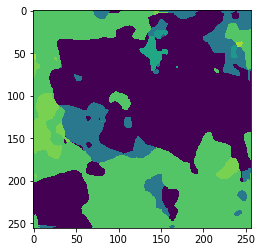

In [0]:
batch_prediction.encode('utf-8')
batch_prediction = tf.io.decode_base64(batch_prediction)
batch_prediction = tf.io.decode_png(batch_prediction)
plt.imshow(np.squeeze(batch_prediction), vmin=0, vmax=15)

Looks like it works too!